In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_igraph_copy import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby
import hashlib
import networkx as nx
import igraph as ig
import itertools
import hashlib

In [2]:
import networkx as nx
import hashlib
import itertools
from collections import defaultdict

import networkx as nx
import itertools
from collections import defaultdict
import hashlib

import networkx as nx
import itertools

In [3]:
def EPM_bipartite_graph_generator_igraph(num_system, num_ancilla):
    """
    igraph를 사용한 EPM 이분 그래프 생성기
    
    Parameters:
    -----------
    num_system : int
        시스템 노드 수
    num_ancilla : int
        앵커라 노드 수
    type : int
        그래프 유형
        
    Yields:
    -------
    igraph.Graph
        생성된 이분 그래프
    """
    import igraph as ig
    import itertools
    
    num_total = num_system + num_ancilla
    
    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)
    
    # ancilla 조합 생성
    if num_ancilla > 0:
        ancilla_combinations_pre = generate_combinations(num_total)
        ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))
    
    for rb_comb in red_blue_combinations:
        if num_ancilla > 0:
            for bl_comb in ancilla_combinations:
                # 노드 이름 생성
                system_node_names = [f'S_{i}' for i in range(num_system)]
                ancilla_node_names = [f'A_{i}' for i in range(num_ancilla)]
                sculpting_node_names = [str(i) for i in range(num_total)]
                
                # 모든 노드 이름 리스트
                all_node_names = system_node_names + ancilla_node_names + sculpting_node_names
                
                # igraph 그래프 생성
                G = ig.Graph()
                G.add_vertices(len(all_node_names))
                
                # 노드 이름 및 속성 설정
                G.vs["name"] = all_node_names
                
                # 노드 카테고리 설정
                categories = ["system_nodes"] * num_system + ["ancilla_nodes"] * num_ancilla + ["sculpting_nodes"] * num_total
                G.vs["category"] = categories
                
                # 이분 그래프 타입 설정 (0: 왼쪽 파티션, 1: 오른쪽 파티션)
                bipartite_types = [0] * (num_system + num_ancilla) + [1] * num_total
                G.vs["bipartite"] = bipartite_types
                
                # 엣지 생성을 위한 리스트
                edges = []
                edge_weights = []
                
                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red_idx = num_system + num_ancilla + vt[0]  # sculpting 노드 인덱스
                    blue_idx = num_system + num_ancilla + vt[1]  # sculpting 노드 인덱스
                    system_idx = rb_index  # system 노드 인덱스
                    
                    edges.append((system_idx, red_idx))
                    edge_weights.append(1.0)
                    
                    edges.append((system_idx, blue_idx))
                    edge_weights.append(2.0)
                
                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    ancilla_idx = num_system + anc_index  # ancilla 노드 인덱스
                    for vt_inx in vt_list:
                        sculpting_idx = num_system + num_ancilla + vt_inx  # sculpting 노드 인덱스
                        edges.append((ancilla_idx, sculpting_idx))
                        edge_weights.append(3.0)
                
                # 그래프에 엣지 추가
                G.add_edges(edges)
                G.es["weight"] = edge_weights
                
                # 각 노드가 최소 2개 이상의 이웃을 갖는지 확인
                if all(G.degree(v) >= 2 for v in range(G.vcount())):
                    yield G
        else:  # num_ancilla == 0 인 경우
            # 노드 이름 생성
            system_node_names = [f'S_{i}' for i in range(num_system)]
            sculpting_node_names = [str(i) for i in range(num_total)]
            
            # 모든 노드 이름 리스트
            all_node_names = system_node_names + sculpting_node_names
            
            # igraph 그래프 생성
            G = ig.Graph()
            G.add_vertices(len(all_node_names))
            
            # 노드 이름 및 속성 설정
            G.vs["name"] = all_node_names
            
            # 노드 카테고리 설정
            categories = ["system_nodes"] * num_system + ["sculpting_nodes"] * num_total
            G.vs["category"] = categories
            
            # 이분 그래프 타입 설정
            bipartite_types = [0] * num_system + [1] * num_total
            G.vs["bipartite"] = bipartite_types
            
            # 엣지 생성을 위한 리스트
            edges = []
            edge_weights = []
            
            # red-blue 엣지 추가
            for rb_index, vt in enumerate(rb_comb):
                red_idx = num_system + vt[0]  # sculpting 노드 인덱스
                blue_idx = num_system + vt[1]  # sculpting 노드 인덱스
                system_idx = rb_index  # system 노드 인덱스
                
                edges.append((system_idx, red_idx))
                edge_weights.append(1.0)
                
                edges.append((system_idx, blue_idx))
                edge_weights.append(2.0)
            
            # 그래프에 엣지 추가
            G.add_edges(edges)
            G.es["weight"] = edge_weights
            
            # 각 노드가 최소 2개 이상의 이웃을 갖는지 확인
            if all(G.degree(v) >= 2 for v in range(G.vcount())):
                yield G

# igraph와 NetworkX 그래프 간 변환 유틸리티 함수
def igraph_to_networkx(g_igraph):
    """igraph 그래프를 NetworkX 그래프로 변환"""
    import networkx as nx
    
    G_nx = nx.Graph()
    
    # 노드 추가
    for v in g_igraph.vs:
        node_attrs = {attr: v[attr] for attr in v.attribute_names()}
        G_nx.add_node(v["name"], **node_attrs)
    
    # 엣지 추가
    for e in g_igraph.es:
        source = g_igraph.vs[e.source]["name"]
        target = g_igraph.vs[e.target]["name"]
        edge_attrs = {attr: e[attr] for attr in e.attribute_names()}
        G_nx.add_edge(source, target, **edge_attrs)
    
    return G_nx

def networkx_to_igraph(G_nx):
    """NetworkX 그래프를 igraph 그래프로 변환"""
    import igraph as ig
    
    g_igraph = ig.Graph()
    
    # 노드 추가
    node_names = list(G_nx.nodes())
    g_igraph.add_vertices(len(node_names))
    g_igraph.vs["name"] = node_names
    
    # 노드 속성 추가
    for attr in set().union(*(d.keys() for n, d in G_nx.nodes(data=True))):
        if attr != "name":  # 이름은 이미 설정됨
            g_igraph.vs[attr] = [G_nx.nodes[n].get(attr) for n in node_names]
    
    # 엣지 추가
    edges = [(node_names.index(u), node_names.index(v)) for u, v in G_nx.edges()]
    g_igraph.add_edges(edges)
    
    # 엣지 속성 추가
    for attr in set().union(*(d.keys() for u, v, d in G_nx.edges(data=True))):
        g_igraph.es[attr] = [G_nx.get_edge_data(u, v).get(attr) for u, v in G_nx.edges()]
    
    return g_igraph

In [4]:
# Canonical Form 생성 (가중치를 고려하지 않음)
def canonical_form_without_weights(ig_graph):
    # iGraph의 canonical_permutation을 사용하여 가중치 없이 처리
    perm = ig_graph.canonical_permutation()  # 색상(color) 정보 없이 permutation 생성
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환

# Canonical Form의 해시 생성
def generate_hash_from_canonical_form(canonical_form):
    # Canonical Form을 문자열로 변환한 뒤 해시값 생성
    canonical_str = str(canonical_form)
    return hashlib.sha256(canonical_str.encode('utf-8')).hexdigest()

In [5]:
# 그래프 리스트 처리 및 그룹화
def process_and_group_by_canonical_form(graph_list):
    canonical_groups = {}  # 해시 값을 키로, 그래프 그룹을 값으로 저장
    for graph in graph_list:
        # Canonical Form 생성 (가중치 고려 안 함)
        canonical_form = canonical_form_without_weights(graph)
        # Canonical Form의 해시 생성
        canonical_hash = generate_hash_from_canonical_form(canonical_form)
        # 동일 해시 값끼리 그룹화
        if canonical_hash not in canonical_groups:
            canonical_groups[canonical_hash] = []  # 새로운 그룹 생성
        canonical_groups[canonical_hash].append(graph)  # 그래프 추가
    return canonical_groups  # 그룹화된 결과 반환

In [6]:
graph_generator = EPM_bipartite_graph_generator_igraph(3, 1)
canonical_groups = process_and_group_by_canonical_form(graph_generator)

In [7]:
def EPM_digraph_from_EPM_bipartite_graph_igraph(B):
    """
    igraph 버전의 EPM 이분 그래프(B)를 방향 그래프(D)로 변환
    
    Parameters:
    -----------
    B : igraph.Graph
        변환할 EPM 이분 그래프
        
    Returns:
    --------
    igraph.Graph
        방향성 있는 EPM 그래프
    """
    import igraph as ig
    import numpy as np
    
    # 시스템 및 앵커라 노드 식별
    system_nodes = [i for i, category in enumerate(B.vs["category"]) if category == "system_nodes"]
    ancilla_nodes = [i for i, category in enumerate(B.vs["category"]) if category == "ancilla_nodes"]
    
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla
    
    # 노드 순서 준비 (시스템 노드, 앵커라 노드, 스컬프팅 노드 순)
    ordered_vertices = []
    ordered_vertices.extend(system_nodes)
    ordered_vertices.extend(ancilla_nodes)
    ordered_vertices.extend([i for i, category in enumerate(B.vs["category"]) if category == "sculpting_nodes"])
    
    # 인접 행렬 계산
    adj_matrix_B = np.array(B.get_adjacency(attribute="weight").data)
    
    # 재정렬된 인접 행렬 생성
    reordered_adj_matrix = np.zeros_like(adj_matrix_B)
    for i, v_i in enumerate(ordered_vertices):
        for j, v_j in enumerate(ordered_vertices):
            reordered_adj_matrix[i, j] = adj_matrix_B[v_i, v_j]
    
    # 방향 그래프용 관련 하위 행렬 추출
    adj_matrix_D = reordered_adj_matrix[:num_total, num_total:]
    
    # 방향 그래프 초기화
    D = ig.Graph(directed=True)
    D.add_vertices(num_total)
    
    # 노드 속성 설정
    categories = []
    node_names = []
    
    for i in range(num_total):
        if i < num_system:
            categories.append("system_nodes")
            node_names.append(f"S_{i}")
        else:
            categories.append("ancilla_nodes")
            node_names.append(f"A_{i-num_system}")
    
    D.vs["category"] = categories
    D.vs["name"] = node_names
    
    # 방향성 있는 엣지 추가
    edges = []
    weights = []
    
    for i in range(num_total):
        for j in range(num_total):
            if adj_matrix_D[i, j] != 0:
                # 방향은 j에서 i로 (원래 코드와 일치)
                edges.append((j, i))
                weights.append(adj_matrix_D[i, j])
    
    D.add_edges(edges)
    D.es["weight"] = weights
    
    return D

# NetworkX 버전도 함께 제공 (igraph 버전을 변환)
def EPM_digraph_from_EPM_bipartite_graph_nx(B_igraph):
    """
    igraph 버전의 EPM 이분 그래프를 NetworkX 방향 그래프로 변환
    
    Parameters:
    -----------
    B_igraph : igraph.Graph
        변환할 EPM 이분 그래프
        
    Returns:
    --------
    networkx.DiGraph
        방향성 있는 EPM 그래프 (NetworkX 형식)
    """
    import networkx as nx
    import numpy as np
    
    # igraph에서 방향 그래프로 변환
    D_igraph = EPM_digraph_from_EPM_bipartite_graph_igraph(B_igraph)
    
    # NetworkX 방향 그래프 초기화
    D_nx = nx.DiGraph()
    
    # 노드 추가
    for i, name in enumerate(D_igraph.vs["name"]):
        category = D_igraph.vs["category"][i]
        D_nx.add_node(name, category=category)
    
    # 엣지 추가
    for edge in D_igraph.es:
        source = D_igraph.vs[edge.source]["name"]
        target = D_igraph.vs[edge.target]["name"]
        weight = edge["weight"]
        D_nx.add_edge(source, target, weight=weight)
    
    return D_nx

# 원래 NetworkX 이분 그래프에서 igraph 방향 그래프 생성
def EPM_digraph_igraph_from_EPM_bipartite_graph_nx(B_nx):
    """
    NetworkX 버전의 EPM 이분 그래프를 igraph 방향 그래프로 변환
    
    Parameters:
    -----------
    B_nx : networkx.Graph
        변환할 EPM 이분 그래프 (NetworkX 형식)
        
    Returns:
    --------
    igraph.Graph
        방향성 있는 EPM 그래프 (igraph 형식)
    """
    # NetworkX에서 igraph로 이분 그래프 변환
    B_igraph = networkx_to_igraph(B_nx)
    
    # igraph 방향 그래프로 변환
    return EPM_digraph_from_EPM_bipartite_graph_igraph(B_igraph)

In [8]:
def is_single_scc_igraph(graph):
    """
    그래프가 단일 강연결 컴포넌트(SCC)인지 확인합니다.
    
    Parameters:
    -----------
    graph : igraph.Graph
        검사할 방향 그래프
        
    Returns:
    --------
    bool
        그래프가 단일 SCC이면 True, 아니면 False
    """
    # igraph에서는 strongly_connected_components() 메서드로 SCC를 찾습니다
    sccs = graph.connected_components(mode="strong")
    
    # 단일 SCC인지 확인: 컴포넌트가 1개이고 전체 노드를 포함해야 함
    return len(sccs) == 1 and len(sccs[0]) == graph.vcount()


def filter_groups_by_scc_igraph(grouped_graphs):
    """
    SCC 조건을 만족하는 그래프 그룹만 필터링합니다 (igraph 버전).
    그룹 구조(해시 키)를 유지합니다.
    
    Parameters:
    -----------
    grouped_graphs (dict): 
        해시 키와 igraph 그래프 리스트를 포함하는 딕셔너리
        
    Returns:
    --------
    dict: 
        SCC 조건을 만족하는 그래프 그룹만 포함하는 딕셔너리
    """
    filtered_groups = {}
    
    for key, graph_list in grouped_graphs.items():
        if len(graph_list) > 0:
            try:
                # 첫 번째 그래프로 SCC 확인
                first_graph = graph_list[0] 
                # 이분 그래프를 방향 그래프로 변환
                D = EPM_digraph_from_EPM_bipartite_graph_igraph(first_graph)
                
                if is_single_scc_igraph(D):
                    # SCC 조건을 만족하면 그룹 전체를 유지
                    filtered_groups[key] = graph_list
            except Exception as e:
                print(f"Error processing graph with key {key}: {e}")
                continue
    
    return filtered_groups


# 하이브리드 접근 방식 (NetworkX 그래프를 포함하는 그룹에 대해)
def filter_groups_by_scc_hybrid(grouped_graphs, is_nx=True):
    """
    SCC 조건을 만족하는 그래프 그룹만 필터링합니다 (NetworkX와 igraph 모두 지원).
    
    Parameters:
    -----------
    grouped_graphs (dict): 
        해시 키와 그래프 리스트를 포함하는 딕셔너리
    is_nx (bool):
        True면 그래프가 NetworkX 형식, False면 igraph 형식
        
    Returns:
    --------
    dict: 
        SCC 조건을 만족하는 그래프 그룹만 포함하는 딕셔너리
    """
    filtered_groups = {}
    
    for key, graph_list in grouped_graphs.items():
        if len(graph_list) > 0:
            try:
                # 첫 번째 그래프로 SCC 확인
                first_graph = graph_list[0]
                
                # 입력 형식에 따라 적절한 함수 사용
                if is_nx:
                    # NetworkX 그래프를 igraph로 변환하여 처리
                    B_igraph = networkx_to_igraph(first_graph)
                    D = EPM_digraph_from_EPM_bipartite_graph_igraph(B_igraph)
                else:
                    # 이미 igraph 형식인 경우
                    D = EPM_digraph_from_EPM_bipartite_graph_igraph(first_graph)
                
                if is_single_scc_igraph(D):
                    # SCC 조건을 만족하면 그룹 전체를 유지
                    filtered_groups[key] = graph_list
            except Exception as e:
                print(f"Error processing graph with key {key}: {e}")
                continue
    
    return filtered_groups


# NetworkX 버전 (레거시 코드와의 호환성을 위해)
def is_single_scc_nx(graph):
    """
    NetworkX 그래프가 단일 강연결 컴포넌트(SCC)인지 확인합니다.
    
    Parameters:
    -----------
    graph : networkx.DiGraph
        검사할 방향 그래프
        
    Returns:
    --------
    bool
        그래프가 단일 SCC이면 True, 아니면 False
    """
    import networkx as nx
    
    sccs = list(nx.strongly_connected_components(graph))
    return len(sccs) == 1 and len(sccs[0]) == len(graph)


def filter_groups_by_scc_nx(grouped_graphs):
    """
    SCC 조건을 만족하는 그래프 그룹만 필터링합니다 (NetworkX 버전).
    그룹 구조(해시 키)를 유지합니다.
    
    Parameters:
    -----------
    grouped_graphs (dict): 
        해시 키와 NetworkX 그래프 리스트를 포함하는 딕셔너리
        
    Returns:
    --------
    dict: 
        SCC 조건을 만족하는 그래프 그룹만 포함하는 딕셔너리
    """
    import networkx as nx
    
    filtered_groups = {}
    
    for key, graph_list in grouped_graphs.items():
        if len(graph_list) > 0:
            try:
                # 첫 번째 그래프로 SCC 확인
                first_graph = graph_list[0]
                D = EPM_digraph_from_EPM_bipartite_graph(first_graph)
                
                if is_single_scc_nx(D):
                    # SCC 조건을 만족하면 그룹 전체를 유지
                    filtered_groups[key] = graph_list
            except Exception as e:
                print(f"Error processing graph with key {key}: {e}")
                continue
    
    return filtered_groups


# 성능 비교 함수
def benchmark_scc_functions(graph_groups, num_repeats=5):
    """
    NetworkX와 igraph의 SCC 필터링 성능을 비교합니다.
    
    Parameters:
    -----------
    graph_groups : dict
        그래프 그룹 딕셔너리
    num_repeats : int
        성능 측정 반복 횟수
    """
    import time
    import networkx as nx
    
    # NetworkX 버전 그래프 그룹 복사
    nx_groups = graph_groups.copy()
    
    # igraph로 변환
    igraph_groups = {}
    for key, graph_list in nx_groups.items():
        igraph_groups[key] = [networkx_to_igraph(g) for g in graph_list]
    
    # NetworkX 함수 성능 측정
    nx_times = []
    for _ in range(num_repeats):
        start_time = time.time()
        nx_filtered = filter_groups_by_scc_nx(nx_groups)
        nx_times.append(time.time() - start_time)
    
    # igraph 함수 성능 측정
    igraph_times = []
    for _ in range(num_repeats):
        start_time = time.time()
        igraph_filtered = filter_groups_by_scc_igraph(igraph_groups)
        igraph_times.append(time.time() - start_time)
    
    # 하이브리드 함수 성능 측정
    hybrid_times = []
    for _ in range(num_repeats):
        start_time = time.time()
        hybrid_filtered = filter_groups_by_scc_hybrid(nx_groups, is_nx=True)
        hybrid_times.append(time.time() - start_time)
    
    # 결과 출력
    print(f"NetworkX 평균 실행 시간: {sum(nx_times)/len(nx_times):.4f}초")
    print(f"igraph 평균 실행 시간: {sum(igraph_times)/len(igraph_times):.4f}초")
    print(f"하이브리드 평균 실행 시간: {sum(hybrid_times)/len(hybrid_times):.4f}초")
    print(f"igraph가 NetworkX보다 {sum(nx_times)/sum(igraph_times):.2f}배 빠름")
    
    # 필터링 결과 검증
    print(f"NetworkX 필터링 결과 그룹 수: {len(nx_filtered)}")
    print(f"igraph 필터링 결과 그룹 수: {len(igraph_filtered)}")
    print(f"하이브리드 필터링 결과 그룹 수: {len(hybrid_filtered)}")
    
    return {
        "nx_times": nx_times,
        "igraph_times": igraph_times,
        "hybrid_times": hybrid_times,
        "nx_filtered": nx_filtered,
        "igraph_filtered": igraph_filtered,
        "hybrid_filtered": hybrid_filtered
    }

In [9]:
canonical_groups

{'7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0': [<igraph.Graph at 0x128487950>,
 '7557ff98f0fb1f45bff4842b435377aa9662820516e3f21f50807ee05670ab2e': [<igraph.Graph at 0x128487850>,
 '36019ea344ba82e088903dc9c14930cdd02310afc42538024b1a6bc35a3336ac': [<igraph.Graph at 0x128487d50>,
 '218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<igraph.Graph at 0x129464450>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<igraph.Graph at 0x129464350>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<igraph.Graph at 0x129464650>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<igraph.Graph at 0x129464550>,
  ...],
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<igraph.Graph at 0x129464850>,
  <igraph.Graph at 0x1382de150>]}

In [10]:
total_elements = sum(len(v) for v in canonical_groups.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

3264


In [11]:
canonical_groups[list(canonical_groups.keys())[0]][0]

In [12]:
igraph_to_networkx(canonical_groups[list(canonical_groups.keys())[0]][0])

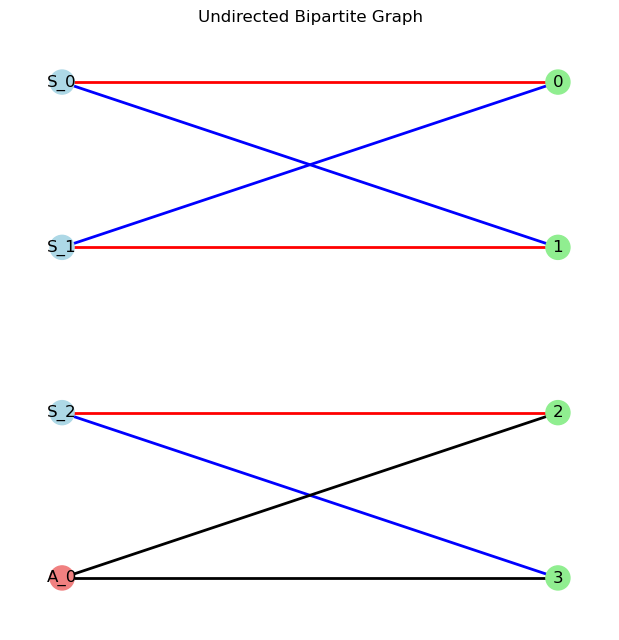

In [13]:
Draw_EPM_bipartite_graph(igraph_to_networkx(canonical_groups[list(canonical_groups.keys())[0]][2]))

In [48]:
# 3. SCC 조건으로 필터링 (그룹 정보 유지)
filtered_groups = filter_groups_by_scc_igraph(canonical_groups)

In [26]:
filtered_groups

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<igraph.Graph at 0x134a98f50>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<igraph.Graph at 0x134a98e50>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<igraph.Graph at 0x134a99150>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<igraph.Graph at 0x134a99050>,
  ...],
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<igraph.Graph at 0x134a99350>,
  <igraph.Graph at 0x1352eec50>]}

In [27]:
total_elements = sum(len(v) for v in filtered_groups.values())  # 모든 리스트 요소 개수 합산
print(total_elements)

2688


In [28]:
import igraph as ig

def extract_unique_bigraphs_with_weights_igraph(graph_list):
    """
    Extract unique bipartite graphs from a list, considering edge weights for isomorphism.
    
    Parameters:
    graph_list (list of ig.Graph): A list of bipartite graphs to process.
    
    Returns:
    list of ig.Graph: A list of unique bipartite graphs.
    """
    # List to store unique graphs
    unique_graphs = []
    
    for new_graph in graph_list:
        # Check if the new graph is isomorphic to any existing unique graph
        is_unique = True
        
        for existing_graph in unique_graphs:
            # 기본 검사: 노드 수와 엣지 수가 같은지 확인
            if new_graph.vcount() != existing_graph.vcount() or new_graph.ecount() != existing_graph.ecount():
                continue
                
            # 가중치 추출 (없으면 기본값 1 사용)
            new_weights = new_graph.es.get_attribute_values("weight") if "weight" in new_graph.edge_attributes() else [1] * new_graph.ecount()
            existing_weights = existing_graph.es.get_attribute_values("weight") if "weight" in existing_graph.edge_attributes() else [1] * existing_graph.ecount()
            
            # VF2 알고리즘으로 동형성 검사 - 가중치를 edge_color로 사용
            if new_graph.isomorphic_vf2(existing_graph, 
                                       edge_color1=new_weights,
                                       edge_color2=existing_weights):
                is_unique = False
                break
        
        # 고유한 그래프만 추가
        if is_unique:
            unique_graphs.append(new_graph)
    
    return unique_graphs

def extract_unique_bigraphs_from_groups_igraph(grouped_graphs):
    """
    그래프 그룹 딕셔너리에서 각 그룹 내의 고유한 그래프를 추출합니다.
    
    Parameters:
    -----------
    grouped_graphs (dict):
        해시 키를 키로, igraph 그래프 리스트를 값으로 가지는 딕셔너리
    
    Returns:
    --------
    dict:
        해시 키를 키로, 고유한 igraph 그래프 리스트를 값으로 가지는 딕셔너리
    """
    result = {}
    
    for key, graph_list in grouped_graphs.items():
        # 각 그래프가 igraph.Graph 인스턴스인지 확인
        valid_graphs = [g for g in graph_list if isinstance(g, ig.Graph)]
        
        if len(valid_graphs) != len(graph_list):
            print(f"경고: 키 {key}에 대해 {len(graph_list) - len(valid_graphs)}개의 유효하지 않은 그래프가 발견되었습니다.")
        
        # 각 그룹에 대해 고유한 그래프만 추출
        if valid_graphs:
            unique_graphs = extract_unique_bigraphs_with_weights_igraph(valid_graphs)
            result[key] = unique_graphs
        else:
            result[key] = []
    
    return result

In [29]:
extract_unique_bigraphs_with_weights_igraph(filtered_groups[list(filtered_groups.keys())[0]])

In [30]:
list(filtered_groups.keys())[0]

'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8'

In [31]:
a = extract_unique_bigraphs_from_groups_igraph(filtered_groups)

In [32]:
list(a.keys())[0]

'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8'

In [33]:
total_elements = sum(len(v) for v in a.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

24


In [34]:
a

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<igraph.Graph at 0x134a98f50>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<igraph.Graph at 0x134a98e50>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<igraph.Graph at 0x134a99150>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<igraph.Graph at 0x134a99050>,
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<igraph.Graph at 0x134a99350>,
  <igraph.Graph at 0x134b01350>]}

In [17]:
def extract_unique_bigraphs_with_weights_igraph(graph_list):
    """
    단순화된 igraph 버전: 엣지 가중치를 고려한 동형성 검사
    
    Parameters:
    -----------
    graph_list (list of igraph.Graph): 처리할 이분 그래프 리스트
    
    Returns:
    --------
    list of igraph.Graph: 고유한 이분 그래프 리스트
    """
    # 고유한 그래프를 저장할 리스트
    unique_graphs = []
    
    for new_graph in graph_list:
        # 새 그래프가 기존의 고유 그래프와 동형인지 확인
        is_unique = True
        
        for existing_graph in unique_graphs:
            # 기본 검사: 노드 수와 엣지 수
            if new_graph.vcount() != existing_graph.vcount() or new_graph.ecount() != existing_graph.ecount():
                continue
                
            # 카테고리 분포 비교
            new_categories = list(new_graph.vs["category"])
            existing_categories = list(existing_graph.vs["category"])
            
            new_category_counts = {}
            existing_category_counts = {}
            
            for cat in new_categories:
                new_category_counts[cat] = new_category_counts.get(cat, 0) + 1
            
            for cat in existing_categories:
                existing_category_counts[cat] = existing_category_counts.get(cat, 0) + 1
                
            if new_category_counts != existing_category_counts:
                continue
            
            # 가중치 분포 비교
            new_weights = sorted(new_graph.es["weight"])
            existing_weights = sorted(existing_graph.es["weight"])
            
            if new_weights != existing_weights:
                continue
                
            # 여기까지 통과했다면 더 정밀한 검사 수행
            # igraph의 isomorphic 함수 사용 (가장 단순한 형태로)
            try:
                # 먼저 가장 기본적인 동형성 검사
                if new_graph.isomorphic(existing_graph):
                    # 추가로 엣지 가중치 패턴도 검사
                    # (이미 가중치 목록이 같다는 것은 확인했으므로, 
                    # 이제 가중치의 분포 패턴이 동형인지만 확인하면 됨)
                    is_isomorphic = True
                    
                    # 가중치에 따라 엣지를 분류하고 각 가중치 그룹의 그래프가 동형인지 확인
                    weight_values = set(new_weights)
                    
                    for weight in weight_values:
                        # 해당 가중치의 엣지만 포함하는 서브그래프 생성
                        new_sub = new_graph.copy()
                        existing_sub = existing_graph.copy()
                        
                        # 다른 가중치의 엣지 삭제
                        new_edges_to_delete = [e.index for e in new_sub.es if e["weight"] != weight]
                        existing_edges_to_delete = [e.index for e in existing_sub.es if e["weight"] != weight]
                        
                        new_sub.delete_edges(new_edges_to_delete)
                        existing_sub.delete_edges(existing_edges_to_delete)
                        
                        # 각 가중치별 서브그래프의 동형성 검사
                        if not new_sub.isomorphic(existing_sub):
                            is_isomorphic = False
                            break
                    
                    if is_isomorphic:
                        is_unique = False
                        break
            except Exception as e:
                # 에러가 발생하면 가능한 다른 방법으로 시도
                # 여기서는 단순히 넘어가고 고유한 그래프로 간주
                print(f"Warning: isomorphism check failed with error: {e}")
                pass
        
        # 고유하면 unique_graphs 리스트에 추가
        if is_unique:
            unique_graphs.append(new_graph)
    
    return unique_graphs


def extract_unique_bigraphs_from_groups_igraph(grouped_graphs):
    """
    그래프 그룹 딕셔너리에서 각 그룹 내의 고유한 그래프를 추출합니다.
    
    Parameters:
    -----------
    grouped_graphs (dict): 
        해시 키를 키로, igraph 그래프 리스트를 값으로 가지는 딕셔너리
        
    Returns:
    --------
    dict: 
        해시 키를 키로, 고유한 igraph 그래프 리스트를 값으로 가지는 딕셔너리
    """
    result = {}
    
    for key, graph_list in grouped_graphs.items():
        # 각 그룹에 대해 고유한 그래프만 추출
        unique_graphs = extract_unique_bigraphs_with_weights_igraph(graph_list)
        result[key] = unique_graphs
    
    return result


# NetworkX 그래프에 대한 변환 유틸리티
def extract_unique_bigraphs_from_groups_hybrid(grouped_graphs, is_nx=True):
    """
    NetworkX 또는 igraph 그래프 그룹에서 고유한 그래프 추출
    
    Parameters:
    -----------
    grouped_graphs (dict): 그래프 그룹 딕셔너리
    is_nx (bool): True면 NetworkX 그래프, False면 igraph 그래프
    
    Returns:
    --------
    dict: 고유한 그래프 그룹 딕셔너리
    """
    if not is_nx:
        # igraph 그래프인 경우 직접 함수 호출
        return extract_unique_bigraphs_from_groups_igraph(grouped_graphs)
    
    # NetworkX 그래프인 경우 먼저 변환 후 처리
    import networkx as nx
    
    result = {}
    
    for key, graph_list in grouped_graphs.items():
        # NetworkX에서 직접 동형성 검사 수행
        edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
        unique_graphs = []
        
        for new_graph in graph_list:
            is_unique = True
            
            for existing_graph in unique_graphs:
                if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
                    is_unique = False
                    break
            
            if is_unique:
                unique_graphs.append(new_graph)
        
        result[key] = unique_graphs
    
    return result

In [23]:
unique_graphs_dict = extract_unique_bigraphs_from_groups_igraph(filtered_groups)

In [24]:
unique_graphs_dict

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<igraph.Graph at 0x12f460150>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<igraph.Graph at 0x12f460050>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<igraph.Graph at 0x12f460350>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<igraph.Graph at 0x12f460250>,
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<igraph.Graph at 0x12f460550>,
  <igraph.Graph at 0x12f478550>]}

In [25]:
total_elements = sum(len(v) for v in unique_graphs_dict.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

20


In [26]:
unique_graphs_dict

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<igraph.Graph at 0x12f460150>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<igraph.Graph at 0x12f460050>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<igraph.Graph at 0x12f460350>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<igraph.Graph at 0x12f460250>,
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<igraph.Graph at 0x12f460550>,
  <igraph.Graph at 0x12f478550>]}

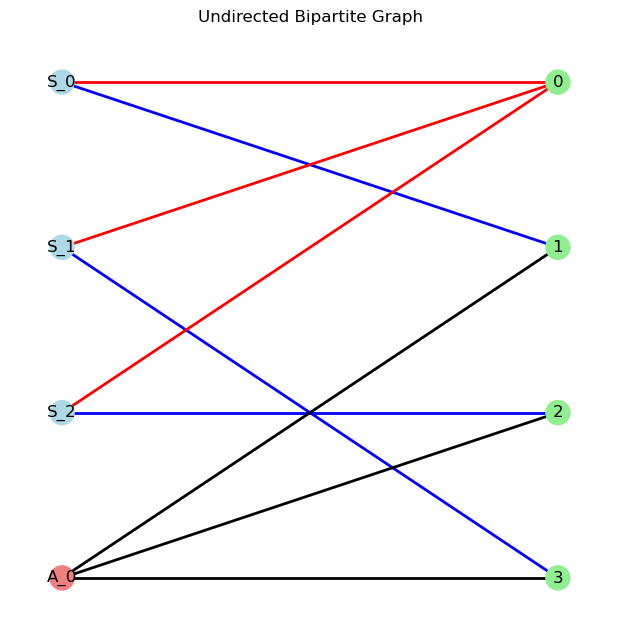

In [22]:
Draw_EPM_bipartite_graph(igraph_to_networkx(canonical_groups[list(unique_graphs_dict.keys())[0]][2]))